# Machine learning prediction of trophic modes
In this notebook, we'll predict whether a taxonomic bin is phototrophic, heterotrophic or mixotrophic in a given sample.

### Setup
First, we'll import the necessary scripts and load the training data from [github](https://github.com/armbrustlab/trophic-mode-ml) and [zenodo](https://zenodo.org/record/4425690#.ZHWzKC9ByLf).
These are stored in the `scripts` folder.
Then, we'll train the model and evaluate its performance.

### What is needed
- The model code, training data & labels in a dedicated folder
- My gene expression data, in taxonomic bins
  - Taxonomic bins: species-level PFAM expression data (PFAM x sample)
  - Only include species that have >800 nonzero unique PFAMs in a sample

### Goal
Per sample, create predictions whether the detected taxonomic bins (that meet the model criteria) are photoautotrophic, mixotrophic, or heterotrophic.

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.dates as mdates
import sys
import plotly.express as px
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings('ignore', category=PerformanceWarning)

## Data preparation

### Option 1: Eukprot

In [108]:
## Load eukprot annotations
data_tax = pd.read_table('../../data/annotation/taxonomy_eukprot/eukprot_DB.firsthit.90plus_alnscore.m8', header=None)
print(f'The eukprot annotation file contains {len(data_tax)} rows')
# Fix transcript names in the first column so that they equal the transcript identifiers in the count files
data_tax.iloc[:, 0] = data_tax.iloc[:, 0].str.split(".", expand=True).drop(columns=1)

## In the second column, split of the EukProt ID off
eukprot_ID = data_tax.iloc[:, 1].str.split("_", expand=True)[0]
data_tax.iloc[:, 1] = eukprot_ID
data_tax.columns = ['query_id', 'target_id', 'p_ident', 'alnlen', 'mismatch', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits']

## Add taxonomic information
eukprot_taxonomy = pd.read_table('../../data/annotation/taxonomy_eukprot/EukProt_included_data_sets.v03.2021_11_22.txt')
print(f'The eukprot taxonomy file contains {len(eukprot_taxonomy)} rows')

# Drop the columns that are not needed
eukprot_taxonomy.drop(columns=['Previous_Names', 'Replaces_EukProt_ID', 'Data_Source_URL', 'Data_Source_Name', 'Paper_DOI', 'Actions_Prior_to_Use',
       'Data_Source_Type', 'Notes', 'Columns_Modified_Since_Previous_Version', 'Merged_Strains',
       'Alternative_Strain_Names', '18S_Sequence_GenBank_ID', '18S_Sequence',
       '18S_Sequence_Source', '18S_Sequence_Other_Strain_GenBank_ID',
       '18S_Sequence_Other_Strain_Name', '18S_and_Taxonomy_Notes'], inplace=True)

# Swap the _ to a space in the Name_to_Use column
eukprot_taxonomy['Name_to_Use'] = eukprot_taxonomy['Name_to_Use'].str.replace('_', ' ')
# Change the name of this column to 'species'
eukprot_taxonomy.rename(columns={'Name_to_Use': 'species'}, inplace=True)

# Merge the annotation and taxonomy files
data_tax = data_tax.merge(eukprot_taxonomy, left_on='target_id', right_on='EukProt_ID', how='left')
print(f'The eukprot annotation merged with taxonomy file contains {len(data_tax)} rows')

# Drop the columns that are not needed
data_tax.drop(columns=['target_id', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits'], inplace=True)
data_tax.head()

The eukprot annotation file contains 468593 rows
The eukprot taxonomy file contains 993 rows
The eukprot annotation merged with taxonomy file contains 468593 rows


,query_id,p_ident,alnlen,mismatch,EukProt_ID,species,Strain,Genus_UniEuk,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup1_UniEuk,Taxogroup2_UniEuk,Taxonomy_UniEuk
0,c_000001100514,0.960,108,4,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans
1,c_000001112094,0.962,91,3,EP00568,Trieres chinensis,PLY606,Trieres,chinensis,Stramenopiles,Ochrophyta,Diatomeae,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Odontellophycidae;Trieres;Trieres chinensis;strain PLY-606
2,c_000001228303,0.952,158,8,EP00568,Trieres chinensis,PLY606,Trieres,chinensis,Stramenopiles,Ochrophyta,Diatomeae,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Odontellophycidae;Trieres;Trieres chinensis;strain PLY-606
3,c_000002029341,1.000,121,0,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans
4,c_000001170245,0.955,127,6,EP00090,Calanus glacialis,NaN,Calanus,glacialis,Opisthokonta,Metazoa,Arthropoda,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;'parahoxozoa';Bilateria;Protostomia;Ecdysozoa;Panarthropoda;Arthropoda;Mandibulata;Pancrustacea;Copepoda;Calanoida;'megacalanoids';Calanidae;Calanus;Calanus glacialis


### Option 2: PhyloDB

In [61]:
# Alternatively, use the phyloDB annotations
## Load PhyloDB alignments
data_tax = pd.read_table('../../data/annotation/taxonomy_phyloDB_extended/phylodb_extended.firsthit.90plus_alnscore.m8',  engine='pyarrow', header=None)
print(f'The mmseqs alignment has {len(data_tax)} hits with a >90 % identity')
data_tax.columns = ['query_id', 'target_id', 'p_ident', 'alnlen', 'mismatch', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits']
print(f'The mmseqs alignment contains {len(data_tax["query_id"].unique())} unique query sequences')
# Fix transcript names in the first column so that they equal the transcript identifiers in the count files
data_tax.iloc[:, 0] = data_tax.iloc[:, 0].str.split(".", expand=True).drop(columns=1)
print(f'The mmseqs alignment contains {len(data_tax["query_id"].unique())} unique query sequences')

# Add taxonomic information
taxonomy = pd.read_table('../../data/annotation/taxonomy_phyloDB_extended/phylodb_1.076.taxonomy_extended.txt')
print(f'The taxonomy file contains {len(taxonomy)} rows')
annotation = pd.read_table('../../data/annotation/taxonomy_phyloDB_extended/phylodb_1.076.annotations_extended.txt', engine='pyarrow', header=None)
print(f'The annotation file contains {len(annotation)} rows, linking transcript IDs to their taxonomy and function')
annotation.columns = ['target_id', 'code', 'strain_name', 'function']

# Add the taxonomy information to the data
data_tax = data_tax.merge(annotation, left_on='target_id', right_on='target_id')
print(f'The alignment merged with annotation file contains {len(data_tax)} rows')

data_tax = data_tax.merge(taxonomy, left_on='strain_name', right_on = 'strain_name')
print(f'The data merged with the taxonomy  file contains {len(data_tax)} rows')

data_tax = data_tax.drop(columns=['code', 'peptide_count'])
# Expand taxonomy path in relevant columns
data_tax[['kingdom', 'superphylum', 'phylum', 'class', 'order', 'family', 'genus', 'species']] = data_tax['taxonomy'].str.split(';', expand = True)

# View data
data_tax.head()

The mmseqs alignment has 954136 hits with a >90 % identity
The mmseqs alignment contains 954136 unique query sequences
The mmseqs alignment contains 954136 unique query sequences
The taxonomy file contains 25996 rows
The annotation file contains 29601232 rows, linking transcript IDs to their taxonomy and function
The alignment merged with annotation file contains 955465 rows
The data merged with the taxonomy  file contains 955465 rows


,query_id,target_id,p_ident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,...,function,taxonomy,kingdom,superphylum,phylum,class,order,family,genus,species
0,c_000003745566,MMETSP0253-20130528|14431_1,0.921,230,18,0,1,230,68,297,...,PF01344.20: Kelch motif PF13964.1: Kelch motif,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dinophyceae_X;Noctilucales;Noctiluca;Noctiluca scintillans,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Noctilucales,Noctiluca,Noctiluca scintillans
1,c_000000945139,MMETSP0253-20130528|14431_1,0.975,95,2,0,1,95,248,342,...,PF01344.20: Kelch motif PF13964.1: Kelch motif,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dinophyceae_X;Noctilucales;Noctiluca;Noctiluca scintillans,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Noctilucales,Noctiluca,Noctiluca scintillans
2,c_000002083138,MMETSP0253-20130528|14431_1,0.939,229,14,0,4,232,114,342,...,PF01344.20: Kelch motif PF13964.1: Kelch motif,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dinophyceae_X;Noctilucales;Noctiluca;Noctiluca scintillans,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Noctilucales,Noctiluca,Noctiluca scintillans
3,c_000002393084,MMETSP0253-20130528|14431_1,0.931,146,10,0,1,146,101,246,...,PF01344.20: Kelch motif PF13964.1: Kelch motif,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dinophyceae_X;Noctilucales;Noctiluca;Noctiluca scintillans,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Noctilucales,Noctiluca,Noctiluca scintillans
4,c_000006249241,MMETSP0253-20130528|14431_1,0.968,193,6,0,3,195,150,342,...,PF01344.20: Kelch motif PF13964.1: Kelch motif,Eukaryota;Alveolata;Dinophyta;Dinophyceae;Dinophyceae_X;Noctilucales;Noctiluca;Noctiluca scintillans,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Dinophyceae_X,Noctilucales,Noctiluca,Noctiluca scintillans


### Functional data

In [15]:
# Load the annotation data
data_func = pd.read_csv('../../data/annotation/functional_eggnog/functional_annotation.emapper.annotations', sep = '\t', engine = 'pyarrow')

# Fix transcript names in the first column so that they equal the transcript identifiers in the count files
# This is necessary because TransDecoder adds .p2 or .p1 to the sequence identifiers
data_func.iloc[:, 0] = data_func.iloc[:, 0].str.split(".", expand=True).drop(columns=1)

# Check the annotation data, how many more hits are there compared to unique query sequences?
print(f'number of rows in eggNOG annotation: {len(data_func)}')
print(f'number of unique query sequences in eggNOG annotation: {len(data_func.iloc[:, 0].unique())}')

# Only retain relevant columns and rename them
data_func = data_func[['#query','PFAMs']]
data_func.columns = ['query_id', 'PFAMs']

number of rows in eggNOG annotation: 2235576
number of unique query sequences in eggNOG annotation: 2235576


In [16]:
data_func.head()

,query_id,PFAMs
0,c_000001511793,Sulfotransfer_2
1,c_000001511845,"AAA_2,ClpB_D2-small"
2,c_000001511972,"Myosin_head,Myosin_tail_1"
3,c_000001512089,-
4,c_000001512133,"Ribosomal_60s,Ribosomal_L10"


I've downloaded the Pfam annotation data from [interprot](https://www.ebi.ac.uk/interpro/download/Pfam/) on 30/05/2023 and stored it in `data/annotation/functional_eggnog/`.
We'll load that dataframe and parse it, to swap the PFAM short names for their descriptions.

In [17]:
# Dictionary to store PFAM ID and description
pfam_mappping = {}
pfam_data = {}

# Read the PFAM data file
with open("../../data/annotation/functional_eggnog/Pfam-A.hmm.dat", "r") as file:
    file_content = file.read()

# Split the file content into individual PFAM entries
pfam_entries = re.split(r"//\n", file_content.strip())

# Process each PFAM entry
for entry in pfam_entries:
    lines = entry.strip().split("\n")
    pfam_short_name_line = lines[1]
    pfam_id_line = lines[2]
    pfam_description_line = lines[3]
    
    # Extract the PFAM short name
    pfam_short_name = pfam_short_name_line.split("ID")[1].strip()
    
    # Extract the PFAM ID
    pfam_id = pfam_id_line.split("AC")[1].strip()

    # Extract the PFAM description
    pfam_description = pfam_description_line.split("DE")[1].strip()

    # Store the PFAM ID and short name in the dictionary
    pfam_mappping[pfam_short_name] = pfam_id
    
    # Store the PFAM ID and description in the dictionary
    pfam_data[pfam_id] = pfam_description

In [18]:
# Add description and ID columns to data_func
data_func['PFAMs_ID'] = data_func['PFAMs'].apply(lambda x: ",".join([pfam_mappping.get(pfam.strip(), "-") for pfam in x.split(",")]))
data_func['PFAMs_description'] = data_func['PFAMs_ID'].apply(lambda x: ",".join([pfam_data.get(pfam.strip(), "-") for pfam in x.split(",")]))

In [19]:
data_func.head()

,query_id,PFAMs,PFAMs_ID,PFAMs_description
0,c_000001511793,Sulfotransfer_2,PF03567.17,Sulfotransferase family
1,c_000001511845,"AAA_2,ClpB_D2-small","PF07724.17,PF10431.12","AAA domain (Cdc48 subfamily),C-terminal, D2-small domain, of ClpB protein"
2,c_000001511972,"Myosin_head,Myosin_tail_1","PF00063.24,PF01576.22","Myosin head (motor domain),Myosin tail"
3,c_000001512089,-,-,-
4,c_000001512133,"Ribosomal_60s,Ribosomal_L10","PF00428.22,PF00466.23","60s Acidic ribosomal protein,Ribosomal protein L10"


In [20]:
# Load the necessary count data
counts = pd.read_csv('../../data/kallisto/tpm.csv', engine='pyarrow')
## This is the transcript read mapping, prior to protein prediction!
# Rename the first column to transcript_id
counts = counts.rename(columns={'target_id': 'transcript_id'})
print(f'{len(counts)} transcripts were quantified (on the nucleotide level) in the kallisto run')
# Transform the data to the long format
counts = counts.melt(id_vars=['transcript_id'],var_name='sample', value_name='TPM')
counts.head()

7113509 transcripts were quantified (on the nucleotide level) in the kallisto run


,transcript_id,sample,TPM
0,c_000000000001,B_120_S11,0.233985
1,c_000000000002,B_120_S11,0.000000
2,c_000000000003,B_120_S11,0.000000
3,c_000000000004,B_120_S11,0.000000
4,c_000000000005,B_120_S11,0.000000


In [62]:
# Combine count and annotation data together
data = data_tax.merge(counts, left_on='query_id', right_on='transcript_id', how='left')
data = data.drop(columns='query_id')

# Add sample metadata
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
data = data.merge(meta, left_on= 'sample', right_on= 'sample', how = 'left')

# View data
print(f'{len(data)} rows are in the data, which should be the amount of annotated proteins times the number of samples')

data = data.merge(data_func, left_on='transcript_id', right_on='query_id')
data = data.drop(columns=['query_id'])
print(len(data))

59238830 rows are in the data, which should be the amount of annotated proteins times the number of samples
41089570


In [65]:
data.head()

,target_id,p_ident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,...,transcript_id,sample,TPM,date,time,month,station,PFAMs,PFAMs_ID,PFAMs_description
0,MMETSP0253-20130528|14431_1,0.921,230,18,0,1,230,68,297,4.757000e-140,...,c_000003745566,B_120_S11,0.0,18/08/2020,9:40,August_2020,120,"BACK,BTB,Kelch_1","PF07707.18,PF00651.34,PF01344.28","BTB And C-terminal Kelch,BTB/POZ domain,Kelch motif"
1,MMETSP0253-20130528|14431_1,0.921,230,18,0,1,230,68,297,4.757000e-140,...,c_000003745566,5_120_S50,0.0,18/05/2021,20:25,May_2021,120,"BACK,BTB,Kelch_1","PF07707.18,PF00651.34,PF01344.28","BTB And C-terminal Kelch,BTB/POZ domain,Kelch motif"
2,MMETSP0253-20130528|14431_1,0.921,230,18,0,1,230,68,297,4.757000e-140,...,c_000003745566,A_780_S3,0.0,22/07/2020,12:30,July_2020,780,"BACK,BTB,Kelch_1","PF07707.18,PF00651.34,PF01344.28","BTB And C-terminal Kelch,BTB/POZ domain,Kelch motif"
3,MMETSP0253-20130528|14431_1,0.921,230,18,0,1,230,68,297,4.757000e-140,...,c_000003745566,5_130_S45,0.0,18/05/2021,9:45,May_2021,130,"BACK,BTB,Kelch_1","PF07707.18,PF00651.34,PF01344.28","BTB And C-terminal Kelch,BTB/POZ domain,Kelch motif"
4,MMETSP0253-20130528|14431_1,0.921,230,18,0,1,230,68,297,4.757000e-140,...,c_000003745566,C_ZG02_S17,0.0,30/09/2020,16:20,September_2020,ZG02,"BACK,BTB,Kelch_1","PF07707.18,PF00651.34,PF01344.28","BTB And C-terminal Kelch,BTB/POZ domain,Kelch motif"


The number of unique species in the dataset is 595


<AxesSubplot:>

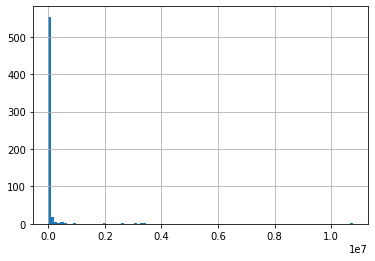

In [66]:
# What is the number of unique species in the dataset?
print(f'The number of unique species in the dataset is {len(data["species"].unique())}')
data['species'].value_counts().hist(bins=100)

In [67]:
# Most of them are detected very low, so let's look at the subset of species that are detected which also have more than 800 unique PFAMs detected for every sample
species = data[['species', 'sample', 'PFAMs_ID', 'TPM']]
## Split the PFAM_ID column into multiple rows and explode them
# Split the PFAM_ID column into multiple columns
species = species.assign(PFAMs_ID=species['PFAMs_ID'].str.split(','))

# Explode the PFAM_ID column
species = species.explode('PFAMs_ID')

# Group by species, sample, and PFAMs_ID
species = species.groupby(['species', 'sample', 'PFAMs_ID']).sum().reset_index()

# Remove all rows with no PFAMs_ID
species = species[species['PFAMs_ID'] != '-']

# Store the species data so that we can easily load it in the future
#species.to_csv('../../data/annotation/functional_eggnog/eukprot_species_PFAM_profiles.csv', index=False)
species.to_csv('../../data/annotation/functional_eggnog/phyloDB_species_PFAM_profiles.csv', index=False)

In [68]:
# Read the species data if it has been stored before
# species = pd.read_csv('../../data/annotation/functional_eggnog/species_PFAM_profiles.csv')
species.head()

,species,sample,PFAMs_ID,TPM
1,Acanthamoeba castellanii str. Neff,1_130_S31,PF00009.30,0.000000
2,Acanthamoeba castellanii str. Neff,1_130_S31,PF00022.22,23.101733
3,Acanthamoeba castellanii str. Neff,1_130_S31,PF00071.25,0.000000
4,Acanthamoeba castellanii str. Neff,1_130_S31,PF00125.27,0.000000
5,Acanthamoeba castellanii str. Neff,1_130_S31,PF00149.31,0.000000


In [69]:
# Print the number of species that have more than 800 unique PFAMs that have an expression level > 0

# Filter the DataFrame to include only species with TPM > 0
filtered_species = species[species['TPM'] > 0]

# Group by sample and species, and count the number of unique PFAMs
species_count = filtered_species.groupby(['sample', 'species'])['PFAMs_ID'].nunique().reset_index()

# Filter the species_count DataFrame to include only samples with more than 800 PFAMs
sample_counts = species_count.groupby('sample').apply(lambda x: (x['PFAMs_ID'] > 800).sum()).reset_index()

# Rename the columns in the sample_counts DataFrame
sample_counts.columns = ['sample', 'species_count']

# Display the resulting DataFrame
print(sample_counts)


        sample  species_count
0    1_130_S31              8
1    1_330_S34              7
2    1_700_S32              2
3    1_780_S33              4
4   1_ZG02_S35             10
..         ...            ...
57   F_130_S25             10
58   F_330_S28             10
59   F_700_S26              5
60   F_780_S27             10
61  F_ZG02_S30             10

[62 rows x 2 columns]


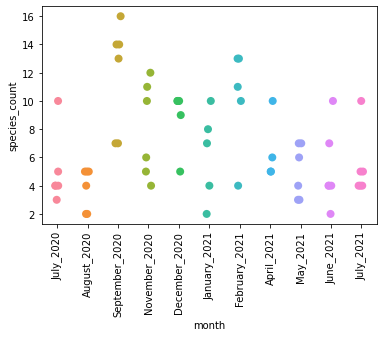

In [70]:
# Add metadata to the sample counts dataframe and plot the results
sample_counts = sample_counts.merge(meta, left_on='sample', right_on='sample', how='left')

# Order the months
month_order = ["July_2020", "August_2020", "September_2020", "November_2020", 
                "December_2020", "January_2021", "February_2021", "April_2021", 
                "May_2021", "June_2021", "July_2021"]

# Plot the results per month
sns.stripplot(data=sample_counts, x='month', y='species_count', order=month_order, size=8);

# X labels should be vertical
plt.xticks(rotation=90);

So it looks like that the amount of species for which we'll be able to predict the trophic mode is variable, but above 6 for most samples. Let's add the names to the dataframe so we now what to select below.

In [71]:
# Create a DataFrame with species names for samples with more than 800 PFAMs
sample_species = species[species['TPM'] > 0].groupby(['sample', 'species'])['PFAMs_ID'].nunique().reset_index()
sample_species = sample_species[sample_species['PFAMs_ID'] > 800]

# Add metadata to the sample counts dataframe and plot the results
sample_species = sample_species.merge(meta, left_on='sample', right_on='sample', how='left')
# Drop irrelevant columns
sample_species = sample_species.drop(columns=['date', 'time'])

# Group by month and sample, and create a list of species
result_df = sample_species.groupby(['month', 'station', 'sample'])['species'].apply(list).reset_index()

# Display the resulting DataFrame
result_df

,month,station,sample,species
0,April_2021,120,4_120_S44,"[Ditylum brightwellii GSO103, Ditylum brightwellii GSO104, Ditylum brightwellii Pop1 (SS4), Guinardia flaccida, Noctiluca scintillans, Odontella sinensis, Phaeocystis antarctica, Strain CCMP1374, Phaeocystis sp. CCMP2710, Thalassiosira rotula CCMP3096, Thalassiosira rotula GSO102]"
1,April_2021,130,4_130_S41,"[Guinardia flaccida, Noctiluca scintillans, Phaeocystis antarctica Caron Lab, Phaeocystis antarctica, Strain CCMP1374, Phaeocystis sp. CCMP2710]"
2,April_2021,330,4_330_S42,"[Guinardia flaccida, Noctiluca scintillans, Phaeocystis antarctica Caron Lab, Phaeocystis antarctica, Strain CCMP1374, Phaeocystis sp. CCMP2710]"
3,April_2021,ZG02,4_ZG02_S43,"[Guinardia flaccida, Noctiluca scintillans, Phaeocystis antarctica Caron Lab, Phaeocystis antarctica, Strain CCMP1374, Phaeocystis sp. CCMP2710, Pseudo-nitzschia delicatissima, Strain UNC1205]"
4,August_2020,120,B_120_S11,"[Ceratium fusus, Strain PA161109, Guinardia flaccida, Noctiluca scintillans, Tripos fusus]"
...,...,...,...,...
57,September_2020,130,C_130_S13,"[Ceratium fusus, Strain PA161109, Ditylum brightwellii GSO103, Ditylum brightwellii GSO104, Ditylum brightwellii GSO105, Ditylum brightwellii Pop1 (SS4), Ditylum brightwellii Strain Pop2 (SS10), Guinardia flaccida, Noctiluca scintillans, Odontella sinensis, Phaeocystis sp. CCMP2710, Thalassiosira punctigera, Thalassiosira rotula CCMP3096, Thalassiosira rotula GSO102, Tripos fusus]"
58,September_2020,330,C_330_S16,"[Ceratium fusus, Strain PA161109, Ditylum brightwellii GSO103, Ditylum brightwellii GSO104, Ditylum brightwellii GSO105, Ditylum brightwellii Pop1 (SS4), Ditylum brightwellii Strain Pop2 (SS10), Favella taraikaensis, Strain Fe Narragansett Bay, Guinardia flaccida, Noctiluca scintillans, Odontella sinensis, Phaeocystis sp. CCMP2710, Stephanopyxis turris, Strain CCMP 815, Thalassiosira punctigera, Tripos fusus]"
59,September_2020,700,C_700_S14,"[Ceratium fusus, Strain PA161109, Guinardia flaccida, Noctiluca scintillans, Odontella sinensis, Phaeocystis sp. CCMP2710, Thalassiosira punctigera, Tripos fusus]"
60,September_2020,780,C_780_S15,"[Ceratium fusus, Strain PA161109, Guinardia flaccida, Noctiluca scintillans, Odontella sinensis, Phaeocystis sp. CCMP2710, Thalassiosira punctigera, Tripos fusus]"


## Test Run

We'll extract one species PFAM signature from one sample and run the prediction for that species.


In [ ]:
test_profile = species[(species['sample'] == '4_330_S42') & (species['species'] == 'Noctiluca scintillans')]

# Reshape, should have the PFAM ID as columns and the TPM values as row values
test_profile = test_profile.drop(columns=['species', 'sample'])
test_profile = test_profile.pivot_table(columns='PFAMs_ID', values='TPM')

# Store into a csv file
test_profile.to_csv('../trophic-mode-ml/data/test_profile.csv')

I ran the model like:

```
./model/predict-tm.py -d data/test_profile.csv -t data/Field_training_data.csv -f data/Extracted_Pfams.csv -l data/Field_training_labels.csv -o data/test
```

And it predicted Photoautotrophic, which I am unsure about. I'll try to run it on the full dataset and see what happens.

## Predict trophic mode

In [31]:
# Indicate where to look for the modules so we can import them into the notebook
sys.path.append('../trophic-mode-ml/model/')

In [32]:
from predict_tm_lib import run_prediction

def run_prediction_for_all_species(df, profiles, train_data_path, feature_path, labels_path):
    """ This will run the trophic mode prediction for all species in the dataset (month, station, sample, species list).
        The results_df used for this was generated above, and only includes species that meet the models' criteria.

    Args:
        df (pandas dataframe): Should contain a column sample and species for which the prediction should be run
        profiles (pandas dataframe): Should contain the profiles for all species in the df. Should have columns sample, species, PFAMs_ID, and TPM
        train_data_path (csv): csv data file with the training data as used in the model by the authors
        feature_path (csv): csv data file with the features as used in the model by the authors
        labels_path (csv): csv data file with the labels as used in the model by the authors

    Returns:
        dataframe: dataframe with a predicted trophic mode for all species. Columns are sample, species, and predicted trophic mode.
    """
    # This will store all results
    all_results = pd.DataFrame()
    # Get unique samples
    samples = df['sample'].unique()
    for sample in samples:
        # Get unique species for this sample
        species = df[df['sample'] == sample]['species'].explode().unique()
        for specie in species:
            # Get profile for this specie in this sample
            profile = profiles[(profiles['sample'] == sample) & (profiles['species'] == specie)]
            # Reshape profile
            profile = profile.drop(columns=['species', 'sample'])
            profile = profile.pivot_table(columns='PFAMs_ID', values='TPM')
            # Save into a csv file
            profile_path = f'../trophic-mode-ml/data/scratch/{sample}_{specie}.csv'
            profile.to_csv(profile_path)
            # Run the prediction model
            predictions = run_prediction(data=profile_path, train=train_data_path, feats=feature_path, labels=labels_path, out=f'../trophic-mode-ml/data/scratch/{sample}_{specie}_preds.csv', rf=False)
            # Collect predictions into a dataframe
            p_df = pd.DataFrame(data={'sample': sample, 'species': specie, 'prediction': predictions})
            # Append to all_results dataframe
            all_results = pd.concat([all_results, p_df], ignore_index=True)
    # Return the final results
    return all_results


In [72]:
# Run the model per month, otherwise the kernel will crash
for month in result_df['month'].unique():
    results = run_prediction_for_all_species(
        result_df[result_df['month'] == month], 
        species, 
        train_data_path='../trophic-mode-ml/data/Field_training_data.csv', 
        feature_path='../trophic-mode-ml/data/Extracted_Pfams.csv', 
        labels_path='../trophic-mode-ml/data/Field_training_labels.csv'
    );
    #results.to_csv(f'../trophic-mode-ml/data/eukprot/{month}_predictions.csv', index=False)
    results.to_csv(f'../trophic-mode-ml/data/phylodb/{month}_predictions.csv', index=False)

In [106]:
# Load the predictions of the different months and concatenate them into one dataframe
predictions = pd.DataFrame()
for month in result_df['month'].unique():
    preds = pd.read_csv(f'../trophic-mode-ml/data/eukprot/{month}_predictions.csv')
    #preds = pd.read_csv(f'../trophic-mode-ml/data/phylodb/{month}_predictions.csv')
    predictions = pd.concat([predictions, preds], ignore_index=True)

In [107]:
predictions.head()

,sample,species,prediction
0,4_120_S44,Ditylum brightwellii,Phot
1,4_120_S44,Noctiluca scintillans,Phot
2,4_120_S44,Phaeocystis globosa,Phot
3,4_120_S44,Pleurobrachia bachei,Phot
4,4_120_S44,Thalassiosira rotula,Phot


## Visualisation and analysis of tropic mode predictions

In [101]:
data_tax.columns

Index(['query_id', 'target_id', 'p_ident', 'alnlen', 'mismatch', 'gapopen',
       'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits', 'strain_name',
       'function', 'taxonomy', 'kingdom', 'superphylum', 'phylum', 'class',
       'order', 'family', 'genus', 'species'],
      dtype='object')

In [109]:
# Add metadata to the predictions dataframe
predictions = predictions.merge(meta, left_on='sample', right_on='sample', how='left')

# Add taxonomic information to the predictions dataframe
## PhyloDB:
#taxonomy_info = data_tax[['kingdom', 'superphylum', 'phylum', 'class', 'order', 'family', 'genus', 'species']]
## EukProt:
taxonomy_info = data_tax[['species', 'Genus_UniEuk', 'Strain', 'Epithet_UniEuk', 'Supergroup_UniEuk', 'Taxogroup1_UniEuk', 'Taxogroup2_UniEuk', 'Taxonomy_UniEuk']]

taxonomy_info = taxonomy_info.drop_duplicates()
predictions = predictions.merge(taxonomy_info, left_on='species', right_on='species', how='left')

# Save the predictions dataframe
predictions.to_csv('../../data/analysis/eukprot_trophic_mode_predictions.csv', index=False)
#predictions.to_csv('../../data/analysis/phylodb_trophic_mode_predictions.csv', index=False)

# Display the resulting dataframe
predictions.head()

,sample,species,prediction,date,time,month,station,Genus_UniEuk,Strain,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup1_UniEuk,Taxogroup2_UniEuk,Taxonomy_UniEuk
0,4_120_S44,Ditylum brightwellii,Phot,27/04/2021,9:25,April_2021,120,Ditylum,CCMP358,brightwellii,Stramenopiles,Ochrophyta,Diatomeae,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Lithodesmiophycidae;Ditylum;Ditylum brightwellii;strain CCMP-358
1,4_120_S44,Noctiluca scintillans,Phot,27/04/2021,9:25,April_2021,120,Noctiluca,NaN,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans
2,4_120_S44,Phaeocystis globosa,Phot,27/04/2021,9:25,April_2021,120,Phaeocystis,CCMP2710,globosa,Haptophyta,Prymnesiophyceae,Prymnesiophyceae,Eukaryota;Diaphoretickes;Haptista;Haptophyta;Prymnesiophyceae;Phaeocystales;Phaeocystis;Phaeocystis globosa;strain CCMP-2710
3,4_120_S44,Pleurobrachia bachei,Phot,27/04/2021,9:25,April_2021,120,Pleurobrachia,NaN,bachei,Opisthokonta,Metazoa,Ctenophora,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;Ctenophora;'pleurobrachiids';Pleurobrachia;Pleurobrachia bachei
4,4_120_S44,Thalassiosira rotula,Phot,27/04/2021,9:25,April_2021,120,Thalassiosira,GSO102,rotula,Stramenopiles,Ochrophyta,Diatomeae,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Thalassiosirophycidae;Thalassiosira;Thalassiosira rotula;strain GSO102


In [77]:
# Load the predictions dataframe if needed
predictions = pd.read_csv('../../data/analysis/eukprot_trophic_mode_predictions.csv')
#predictions = pd.read_csv('../../data/analysis/phylodb_trophic_mode_predictions.csv')

In [112]:
# I want to check for which genera the predictions are not uniform within that genus for a given sample
# tax_level = 'species' 
tax_level = 'Taxonomy_UniEuk'

## Extract sample, genus, and prediction
pred_subset = predictions[['sample', tax_level, 'prediction']]
## Group by sample and genus, and create a list of predictions
pred_subset = pred_subset.groupby(['sample', tax_level])['prediction'].apply(list).reset_index()
## Add a column with the number of unique predictions
pred_subset['unique_preds'] = pred_subset['prediction'].apply(lambda x: len(set(x)))

# Display the samples and the genera for which the predictions are not uniform within that genus
pred_subset[pred_subset['unique_preds'] > 1][tax_level].unique()

array([], dtype=object)

In [113]:
pred_subset

,sample,Taxonomy_UniEuk,prediction,unique_preds
0,1_130_S31,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Lithodesmiophycidae;Ditylum;Ditylum brightwellii;strain CCMP-358,[Phot],1
1,1_130_S31,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Thalassiosirophycidae;Thalassiosira;Thalassiosira punctigera;strain Tpunct2005C2,[Phot],1
2,1_330_S34,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;'parahoxozoa';Bilateria;Protostomia;Ecdysozoa;Panarthropoda;Arthropoda;Mandibulata;Pancrustacea;Copepoda;Calanoida;'megacalanoids';Calanidae;Calanus;Calanus glacialis,[Phot],1
3,1_330_S34,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;'parahoxozoa';Bilateria;Protostomia;Ecdysozoa;Panarthropoda;Arthropoda;Mandibulata;Pancrustacea;Copepoda;Calanoida;'megacalanoids';Calanidae;Neocalanus;Neocalanus flemingeri,[Phot],1
4,1_330_S34,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;Ctenophora;'pleurobrachiids';Pleurobrachia;Pleurobrachia bachei,[Phot],1
...,...,...,...,...
223,F_780_S27,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Odontellophycidae;Trieres;Trieres chinensis;strain PLY-606,[Phot],1
224,F_780_S27,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Thalassiosirophycidae;Thalassiosira;Thalassiosira punctigera;strain Tpunct2005C2,[Phot],1
225,F_ZG02_S30,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Lithodesmiophycidae;Ditylum;Ditylum brightwellii;strain CCMP-358,[Phot],1
226,F_ZG02_S30,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Mediophyceae;Odontellophycidae;Trieres;Trieres chinensis;strain PLY-606,[Phot],1


In [114]:
pred_subset['prediction'].value_counts()

[Phot]    218
[Het]       8
[Mix]       2
Name: prediction, dtype: int64

So only Ditylum and Phaeocystis have contrasting predictions for different genera in the same sample. 

In [115]:
# Is odontella a genus that is always predicted as one trophic mode?
pred_subset[pred_subset['genus'] == 'Odontella']['prediction'].explode().value_counts()
## yes

# Now extract the genera that have variable predictions across samples
pred_subset = predictions[['sample', 'genus', 'prediction']]
pred_subset = pred_subset.groupby(['genus'])['prediction'].apply(list).reset_index()

# Check if the list in the prediction column contains more than one unique value
pred_subset['unique_preds'] = pred_subset['prediction'].apply(lambda x: len(set(x)))

# Print the genera that have variable predictions across samples
pred_subset[pred_subset['unique_preds'] > 1]['genus'].unique()

KeyError: 'genus'

In [97]:
# Print the genera that have uniform predictions across samples
pred_subset[pred_subset['unique_preds'] == 1]['genus'].unique()

array(['Asterionellopsis', 'Chaetoceros', 'Favella', 'Heterocapsa',
       'Leptocylindrus', 'Mesodinium', 'Odontella', 'Pseudo-nitzschia',
       'Stephanopyxis', 'Thalassiosira'], dtype=object)

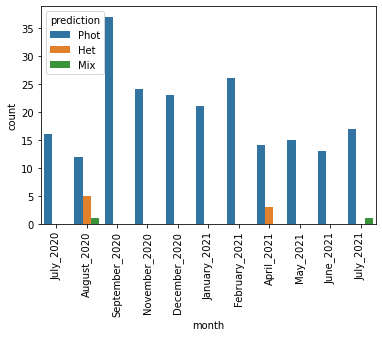

In [116]:
# Order the months
month_order = ["July_2020", "August_2020", "September_2020", "November_2020", 
                "December_2020", "January_2021", "February_2021", "April_2021", 
                "May_2021", "June_2021", "July_2021"]
# Plot the count of the three trophic modes per month
sns.countplot(data=predictions, x='month', hue='prediction', order=month_order);
# X labels should be vertical
plt.xticks(rotation=90);

In [88]:
# Make a nice heatmap per class that shows the count of trophic modes per month
# First, get the counts per month and class
counts = predictions.groupby(['month', 'class', 'prediction']).size().reset_index(name='counts')

# Get the order of the months correct
counts['month'] = pd.Categorical(counts['month'], categories=month_order)
# Create a heatmap for each class
for c in counts['class'].unique():
    # Get the counts for this class
    c_counts = counts[counts['class'] == c]
    # Pivot the dataframe
    c_counts = c_counts.pivot(index='prediction', columns='month', values='counts')
    # Plot the heatmap
    sns.heatmap(c_counts, cmap='YlGnBu', annot=True)
    # Set the title
    plt.title(c)
    # Save the figure
    plt.savefig(f'../../figures/functional_analysis/trophic_mode_average_count_per_sample_heatmap_{c}.png', dpi=600, bbox_inches='tight')
    # Show the figure
    plt.show()


KeyError: 'month'

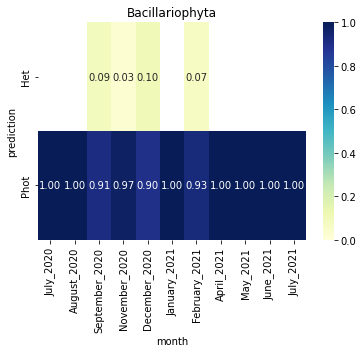

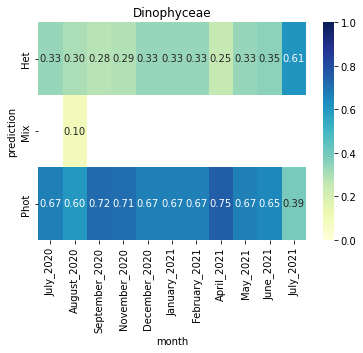

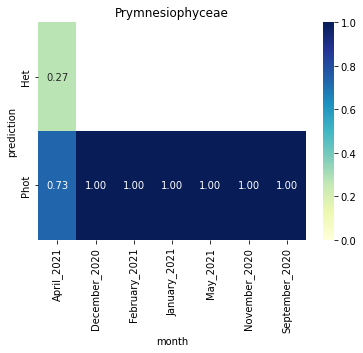

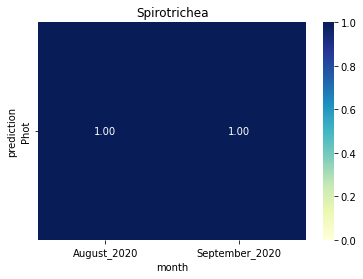

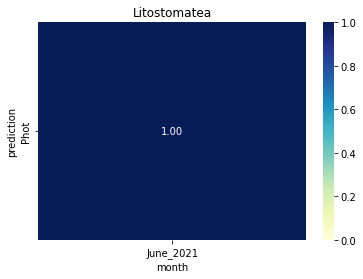

In [112]:
# Make a nice heatmap per class that shows the proportion of trophic modes per month
# First, get the counts per month and class
counts = predictions.groupby(['month', 'class', 'prediction']).size().reset_index(name='counts')
# Change the counts to proportions
counts['counts'] = counts.groupby(['month', 'class'])['counts'].apply(lambda x: x / float(x.sum()))
# Get the order of the months correct
counts['month'] = pd.Categorical(counts['month'], categories=month_order)
# Create a heatmap for each class
for c in counts['class'].unique():
    # Get the counts for this class
    c_counts = counts[counts['class'] == c]
    # Pivot the dataframe
    c_counts = c_counts.pivot(index='prediction', columns='month', values='counts')
    # Plot the heatmap
    sns.heatmap(c_counts, cmap='YlGnBu', annot=True, fmt='.2f', vmin=0, vmax=1)
    # Set the title
    plt.title(c)
    # Save the figure
    plt.savefig(f'../../figures/functional_analysis/trophic_mode_heatmap_{c}.png', dpi=600, bbox_inches='tight')
    # Show the figure
    plt.show()


In [113]:
# Calculate relative abundance of each prediction per month
rel_abundance = (predictions[['month', 'station', 'prediction']].groupby(['month', 'prediction'])
                       .size()
                       .groupby(level=0).apply(lambda x: 100 * x / x.sum())
                       .reset_index(name='relative abundance'))

# Set the color palette
color_map = {
    'Phot': 'green',
    'Mix': 'black',
    'Het': 'red'
}

# Plot the relative abundance of the three trophic modes per month
fig = px.histogram(rel_abundance.sort_values("month", ascending=False),
             x = "relative abundance",
             y = "month",
             color = "prediction",
             orientation='h',
             color_discrete_map=color_map,
             category_orders={"month": ["July_2020", "August_2020", "September_2020",
                "November_2020", "December_2020", "January_2021",
                "February_2021", "April_2021", "May_2021",
                "June_2021", "July_2021"]})

pixels_per_cm = 37.7952755906

fig.update_layout(
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=8  # Set the font size
    ),
    autosize=False,
    width= 8.5 * pixels_per_cm,
    height= 7.5 * pixels_per_cm,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='Ratio of predicted trophic modes (%)',
    yaxis_title_text=None,
)

fig.show()

# save figure as svg
fig.write_image("../../figures/functional_analysis/predicted_trophic_mode_ratios_per_month.svg")

In [115]:
# Now make a lmplot of the relative abundance of the three trophic modes per month
# Calculate relative abundance of each prediction per sample
rel_abundance = (predictions[['sample', 'prediction', 'species']].groupby(['sample', 'prediction'])).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index(name='relative abundance')

# Add month to the relative abundance dataframe
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
rel_abundance = rel_abundance.merge(meta[['month']], left_on='sample', right_index=True, how='left')
# Convert month to datetime
rel_abundance['month'] = pd.to_datetime(rel_abundance['month'], format='%B_%Y')

# Plot the relative abundance of the three trophic modes per month
fig = px.scatter(rel_abundance,
                x = "month",
                y = "relative abundance",
                color = "prediction",
                color_discrete_map=color_map,
                trendline='lowess')

fig.update_layout(
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=8  # Set the font size
    ),
    autosize=False,
    width= 8.5 * pixels_per_cm,  # width in pixels
    height= 7.5 * pixels_per_cm,  # height in pixels
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='Ratio of predicted trophic modes (%)',
    yaxis_title_text=None,
)
                 
fig.show()

# Save figure as svg
fig.write_image(f'../../figures/functional_analysis/predicted_trophic_mode_ratios_per_month_lmplot.svg')